In [12]:
import os
import random
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# library for evaluation
from sklearn import metrics

# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread


from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

In [26]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [13]:
# load training data
df = pd.read_csv("dogcat/train.csv")

# summarise the details
print(f'Number of entries: {len(df)}')
df.head()

Number of entries: 10000


,Id,Label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [14]:
len(df)

10000

In [15]:
dog_list = []
for i in range(0, len(df)):
    if df.iloc[i]['Label']== 'dog':
        dog_list.append(df.iloc[i]['Id'])

cat_list = []
for i in range(0, len(df)):
    if df.iloc[i]['Label']== 'cat':
        cat_list.append(df.iloc[i]['Id'])

In [16]:
print("Total images for dog:", len(dog_list))
print("\nTotal images for cat:", len(cat_list))

Total images for dog: 5011

Total images for cat: 4989


In [17]:
filenames = []
categories = []

for i in range(0, len(dog_list)):
#     categories.append('dog')
    categories.append(1)
    filenames.append(str(dog_list[i]) + '.jpg')
    
for i in range(0, len(cat_list)):
#     categories.append('cat')
    categories.append(0)
    filenames.append(str(cat_list[i]) + '.jpg')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [19]:
df.head()

,filename,category
0,2.jpg,1
1,6.jpg,1
2,10.jpg,1
3,12.jpg,1
4,14.jpg,1


<AxesSubplot:>

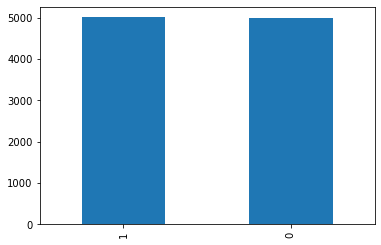

In [9]:
df['category'].value_counts().plot.bar()

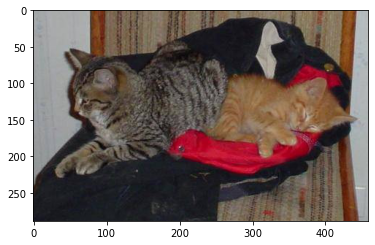

In [24]:
sample = random.choice(filenames)
image = load_img("dogcat/train_images/"+sample)
plt.imshow(image)

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)      

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [29]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=100)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

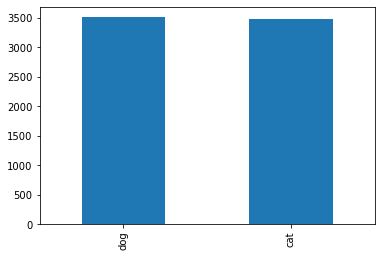

In [32]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

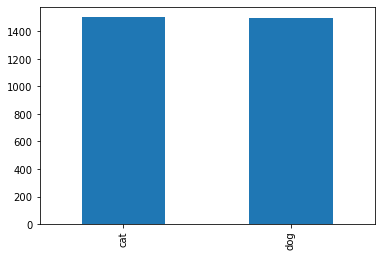

In [33]:
validate_df['category'].value_counts().plot.bar()

In [36]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [37]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogcat/train_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 7000 validated image filenames belonging to 2 classes.


In [38]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogcat/train_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3000 validated image filenames belonging to 2 classes.


In [39]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "dogcat/train_images/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


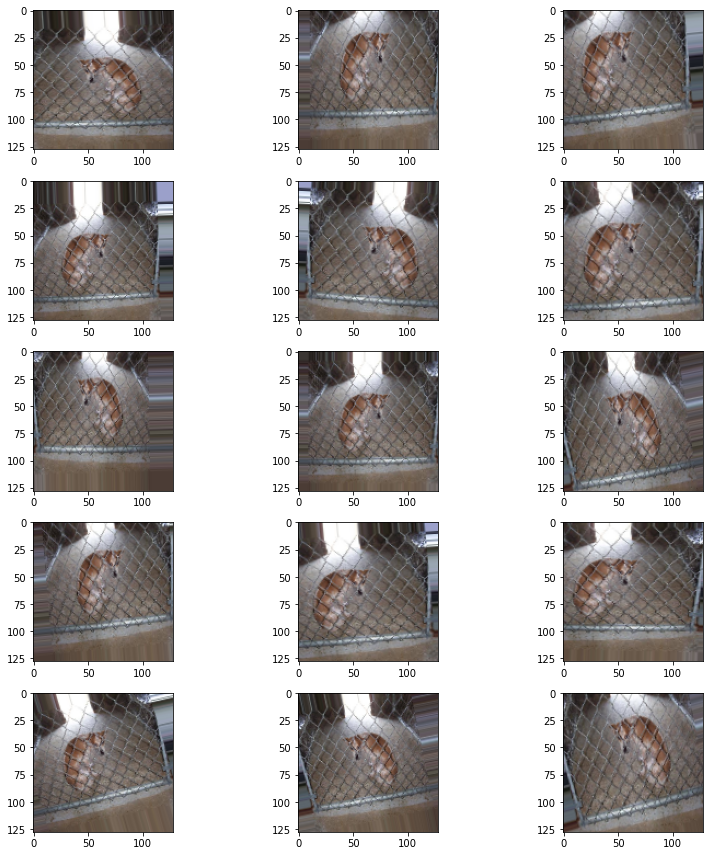

In [40]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [41]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-41-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
466/466 [==============================] - 388s 828ms/step - loss: 0.9498 - accuracy: 0.5828 - val_loss: 0.6402 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 2/50
466/466 [==============================] - 362s 776ms/step - loss: 0.6613 - accuracy: 0.6409 - val_loss: 0.5932 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 3/50
466/466 [==============================] - 363s 778ms/step - loss: 0.6076 - accuracy: 0.6809 - val_loss: 0.8197 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 4/50
466/466 [==============================] - 306s 656ms/step - loss: 0.5721 - accuracy: 0.7130 - val_loss: 0.5619 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 5/50
466/466 [==============================] - 310s 665ms/step - loss: 0.5533 - accuracy: 0.7238 - val_loss: 0.5264 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 6/50
466/466 [==============================] - 309s 664ms/step - loss: 0.5317 - accuracy: 0.7426 - val_loss: 0.5985 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 7/50
466/466 [==========================

466/466 [==============================] - 302s 647ms/step - loss: 0.3777 - accuracy: 0.8336 - val_loss: 0.3530 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 22/50
466/466 [==============================] - 302s 647ms/step - loss: 0.3740 - accuracy: 0.8394 - val_loss: 0.4441 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 23/50
466/466 [==============================] - 311s 667ms/step - loss: 0.3654 - accuracy: 0.8404 - val_loss: 0.4714 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 24/50
466/466 [==============================] - 323s 694ms/step - loss: 0.3583 - accuracy: 0.8399 - val_loss: 0.3162 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 25/50
466/466 [==============================] - 302s 647ms/step - loss: 0.3657 - accuracy: 0.8411 - val_loss: 0.3676 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 26/50
466/466 [==============================] - 301s 645ms/step - loss: 0.3557 - accuracy: 0.8467 - val_loss: 0.4972 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 27/50
466/466 [==============================]

466/466 [==============================] - 300s 644ms/step - loss: 0.3231 - accuracy: 0.8636 - val_loss: 0.2824 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 42/50
466/466 [==============================] - 299s 641ms/step - loss: 0.3242 - accuracy: 0.8628 - val_loss: 0.2946 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 43/50
466/466 [==============================] - 305s 655ms/step - loss: 0.3199 - accuracy: 0.8631 - val_loss: 0.3216 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 44/50
466/466 [==============================] - 305s 655ms/step - loss: 0.3169 - accuracy: 0.8639 - val_loss: 0.2959 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 45/50
466/466 [==============================] - 302s 648ms/step - loss: 0.3170 - accuracy: 0.8660 - val_loss: 0.3629 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 46/50
466/466 [==============================] - 301s 645ms/step - loss: 0.3197 - accuracy: 0.8647 - val_loss: 0.3195 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 47/50
466/466 [==============================]

In [42]:
model.save_weights("model.h5")

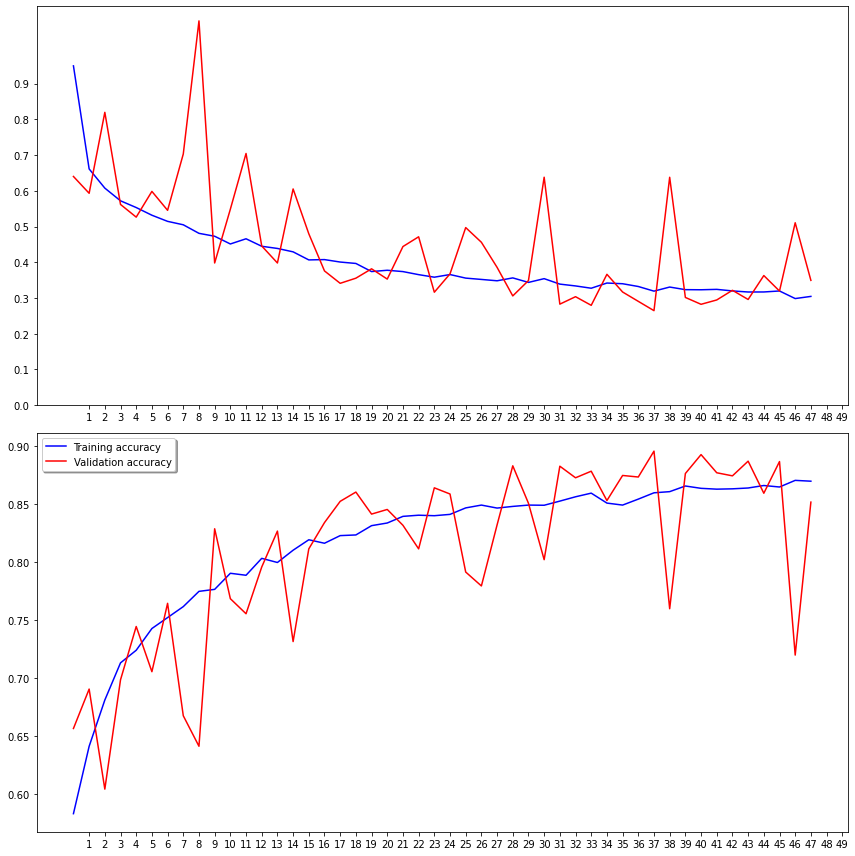

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [82]:
range_len = len(os.listdir("dogcat/test_images/"))

filenames = []

for i in range(1, range_len+1):
    filenames.append(str(i) + ".jpg")


In [84]:
test_df = pd.DataFrame({
    'filename': filenames
})
nb_samples = test_df.shape[0]

In [86]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogcat/test_images/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 validated image filenames.


In [87]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-87-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [88]:
test_df['category'] = np.argmax(predict, axis=-1)

In [89]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

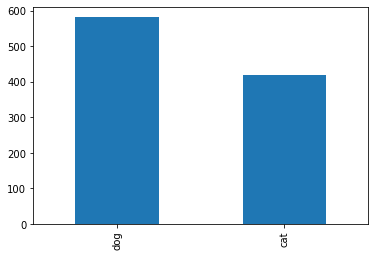

In [107]:
test_df['category'].value_counts().plot.bar()

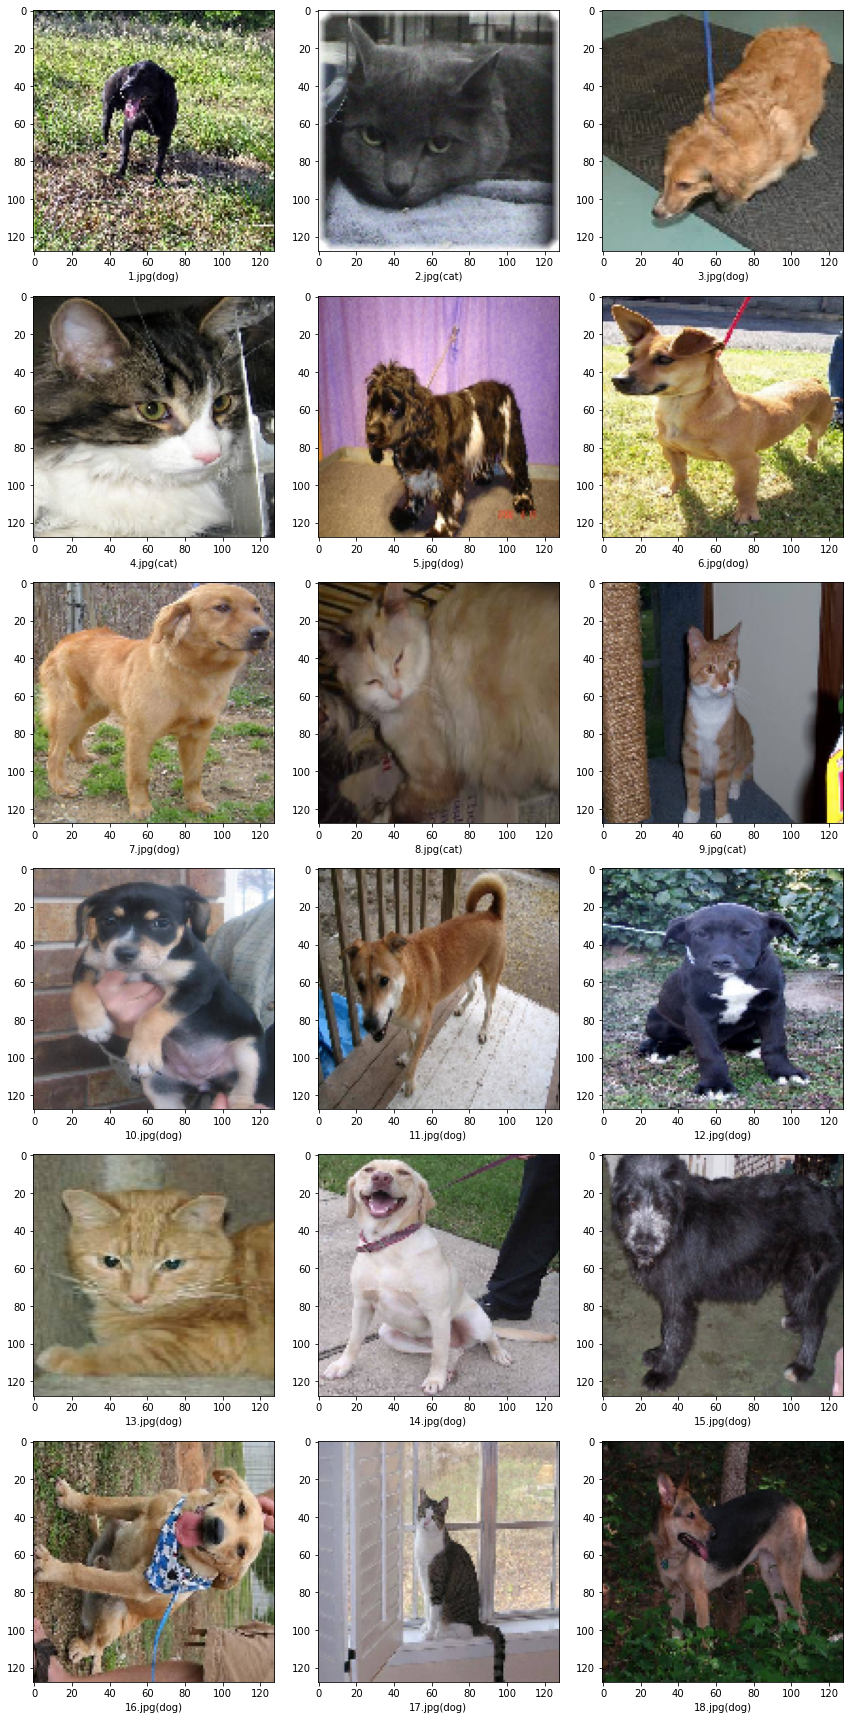

In [109]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dogcat/test_images/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [110]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

In [111]:
submission_df

,id,label
0,1,dog
1,2,cat
2,3,dog
3,4,cat
4,5,dog
...,...,...
995,996,dog
996,997,dog
997,998,dog
998,999,cat


In [113]:

submission_df.to_csv('test_predictions.csv', index=False)